# Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.



### Importing general dependencies

In [3]:
#Import general dependencies

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Input, Add, Flatten, Dropout, MaxPool2D, MaxPooling2D
from keras.initializers import glorot_uniform as gu
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


#!git clone https://github.com/sofzcc/project-1-deep-learning-image-classification-with-cnn/


### Data Loading


In [4]:
!kaggle datasets download -d alessiocorrado99/animals10 -p /content

# Define the path to the zip file
zip_file_path = '/content/animals10.zip'

# Define the directory where you want to extract the files
extract_dir = '/content/animals10/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
100% 585M/586M [00:16<00:00, 43.6MB/s]
100% 586M/586M [00:16<00:00, 37.8MB/s]


In [5]:
import random
import shutil


animals_dir = '/content/animals10/raw-img'
test_dir = '/content/animals10/test-img'  # New directory for test images

# Create test_dir if it doesn't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Move a portion of images from each class in animals_dir to test_dir
for class_name in os.listdir(animals_dir):
    class_dir = os.path.join(animals_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    if os.path.isdir(class_dir):
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)

        # Get a list of image files in the class directory
        file_list = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Randomly select 10% of the images to move to the test directory
        num_test_images = int(len(file_list) * 0.1)
        test_files = random.sample(file_list, num_test_images)

        for file_name in test_files:
            shutil.move(os.path.join(class_dir, file_name), os.path.join(test_class_dir, file_name))


# Get class names
class_names = [class_name for class_name in os.listdir(animals_dir) if os.path.isdir(os.path.join(animals_dir, class_name))]


#Data Exploration

Explore the Dataset: Get an overview of the data, including the number of classes, number of images per class, and sample images.


In [6]:
# List all classes
print("The original dataset contains the following classes:")
for class_name in class_names:
    print(f"{class_name}")

# Counting total images per class
image_class = {}
for class_name in class_names:
    class_dir = os.path.join(animals_dir, class_name)
    image_class[class_name] = len(os.listdir(class_dir))

print("\n\nTotal images per class in the original dataset:")
for class_name, count in image_class.items():
    print(f"{class_name} : {count}")



The original dataset contains the following classes:
ragno
cavallo
gallina
pecora
gatto
scoiattolo
cane
elefante
mucca
farfalla


Total images per class in the original dataset:
ragno : 4339
cavallo : 2361
gallina : 2789
pecora : 1638
gatto : 1502
scoiattolo : 1676
cane : 4377
elefante : 1302
mucca : 1680
farfalla : 1901


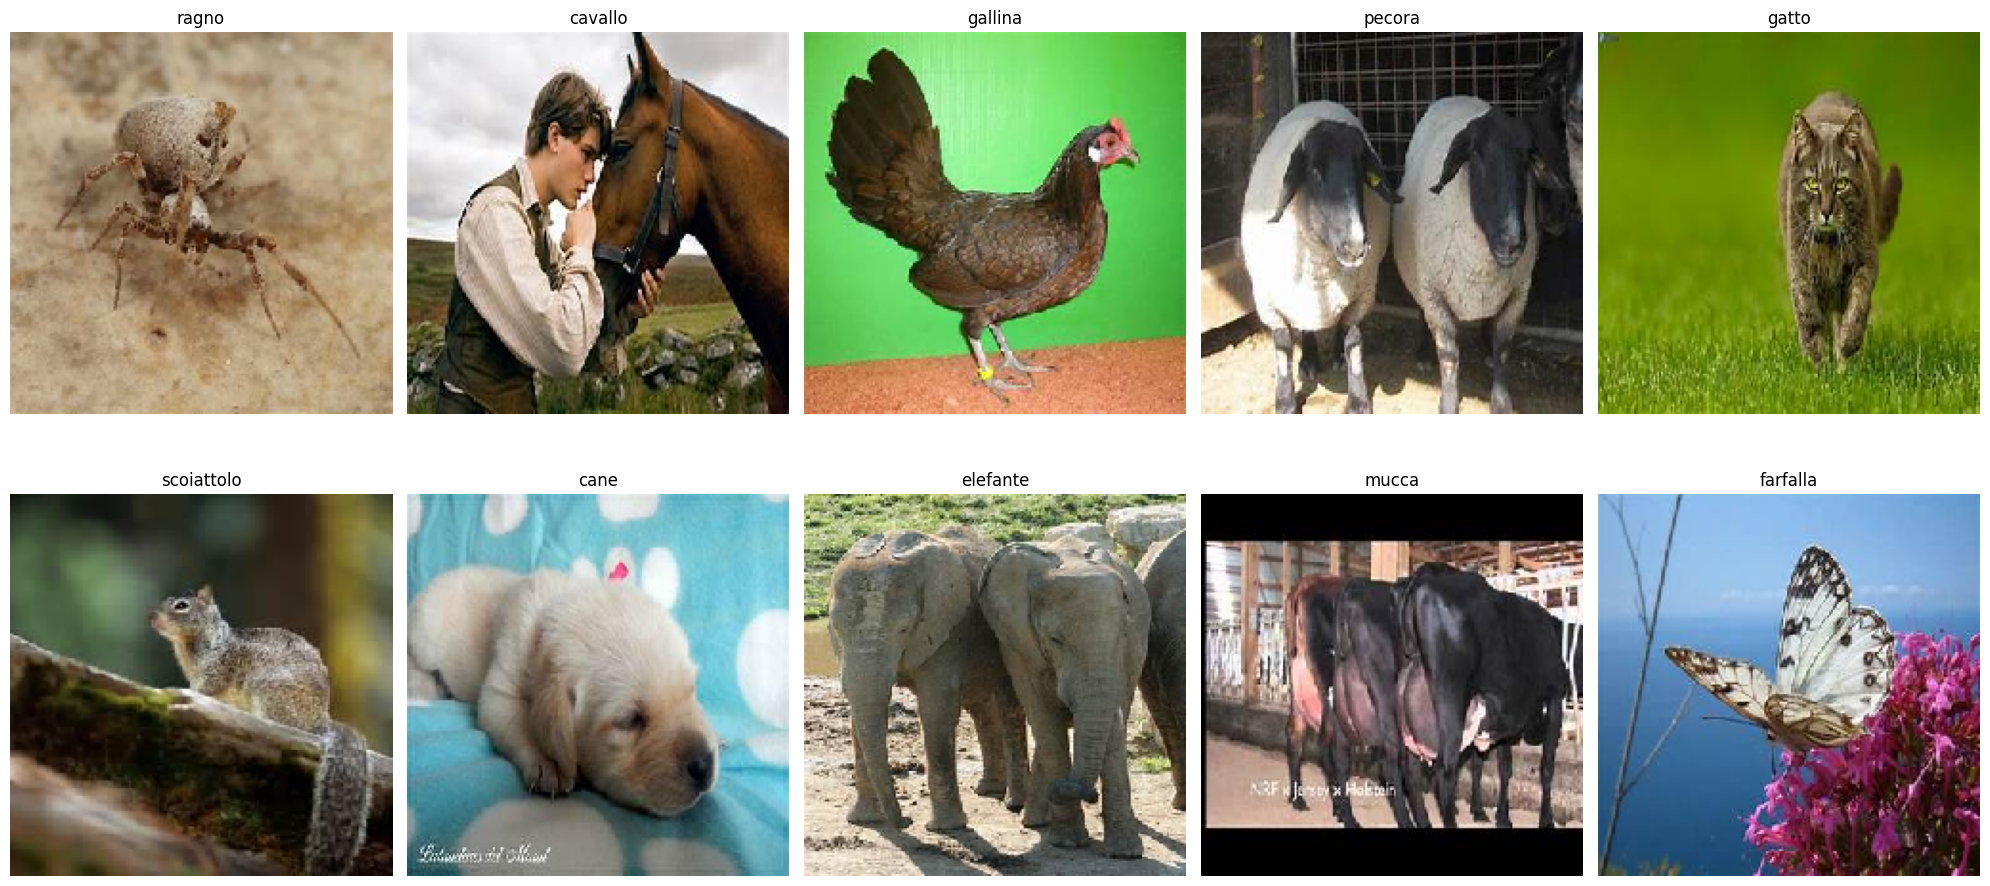

In [7]:
#Plotting sample images from each class

fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20,10))
axes = axes.flatten()
for ax, class_name in zip(axes, class_names):
    class_dir = os.path.join(animals_dir, class_name)
    file_list = [f for f in os.listdir(class_dir) if os.path.isfile(os.path.join(class_dir, f))]
    if file_list:
      path_sample = os.path.join(class_dir, file_list[0])  # Selecting the first file
      img = image.load_img(path_sample, target_size=(200, 200))
      ax.imshow(img)
      ax.set_title(class_name)
      ax.axis('off')
    else:
      continue
plt.tight_layout()
plt.show()

### Data Preprocessing

Preprocessing (e.g., normalization, resizing, augmentation).
Create visualizations of some images, and labels.


In [8]:


# Create ImageDataGenerators for training and validation sets
data_generator = ImageDataGenerator(
    rescale=1./255.0,
    validation_split=0.2,  # Split for training and validation
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    rotation_range=30,
    fill_mode="nearest"
)

# Create ImageDataGenerator for test set
test_val_data_generator = ImageDataGenerator(rescale=1./255.0)

# Generate training set
train_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(200, 200),
    batch_size=64,
    class_mode='sparse',
    subset='training'
)

# Generate validation set
val_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(200, 200),
    batch_size=64,
    class_mode='sparse',
    subset='validation'
)

# Generate test set
test_set = test_val_data_generator.flow_from_directory(
    test_dir,
    target_size=(200, 200),
    batch_size=64,
    class_mode='sparse'
)

Found 18856 images belonging to 10 classes.
Found 4709 images belonging to 10 classes.
Found 2614 images belonging to 10 classes.


## Model Architecture

Design a CNN architecture suitable for image classification.
Include convolutional layers, pooling layers, and fully connected layers.


In [ ]:
from keras.optimizers import RMSprop

#MReLU is an element wise operation (applied per pixel) and replaces all negative pixel values in the feature map by zero
#and to introduce non-linearity to the network
#Other non linear functions such as tanh or sigmoid can also be
#used instead of ReLU, but ReLU has been found to perform better in most situations


#gradually reduce the spatial dimensions through the network
# while still allowing the filters to have a sufficient receptive field in the second layer.

# cnn_model = tf.keras.models.Sequential([
#     Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)'),
#     BatchNormalization(),
#     MaxPooling2D((2, 2)),
#     Dropout(rate=0.15),

#     Conv2D(128, (3, 3), activation='relu'),
#     BatchNormalization(),
#     MaxPooling2D(pool_size=(2, 2)),
#     Dropout(rate=0.20),

#     Flatten(),
#     Dense(256, activation='relu'),
#     BatchNormalization(),
#     Dropout(rate=0.30),
#     Dense(3, activation='softmax'),
# ]
# )

# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



# early_stopping = EarlyStopping(monitor='accuracy', patience = 5, restore_best_weights = True)
# reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)

from keras.optimizers import RMSprop

#MReLU is an element wise operation (applied per pixel) and replaces all negative pixel values in the feature map by zero
#and to introduce non-linearity to the network
#Other non linear functions such as tanh or sigmoid can also be
#used instead of ReLU, but ReLU has been found to perform better in most situations


#gradually reduce the spatial dimensions through the network
# while still allowing the filters to have a sufficient receptive field in the second layer.

cnn_model = tf.keras.models.Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(200, 200, 3)),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(rate=0.15),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(rate=0.20),

    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    tf.keras.layers.ReLU(),
    Dropout(rate=0.30),
    Dense(10, activation='softmax'),
]
)

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])



early_stopping = EarlyStopping(monitor='accuracy', patience = 5, restore_best_weights = True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001)



In [10]:

cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 198, 198, 64)      1792      
                                                                 
 batch_normalization (Batch  (None, 198, 198, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 99, 99, 64)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 99, 99, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 97, 97, 128)       73856     
                                                                 
 batch_normalization_1 (Bat  (None, 97, 97, 128)       5

##Model Training

Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
Utilize techniques such as early stopping to prevent overfitting.


In [ ]:
history = cnn_model.fit(train_set, validation_data=val_set, epochs=50, callbacks=[early_stopping, reduce_lr], verbose=2)

Epoch 1/50
295/295 - 912s - loss: 1.7654 - accuracy: 0.4020 - val_loss: 2.0458 - val_accuracy: 0.3682 - lr: 1.0000e-04 - 912s/epoch - 3s/step
Epoch 2/50
295/295 - 929s - loss: 1.6270 - accuracy: 0.4394 - val_loss: 1.8324 - val_accuracy: 0.4334 - lr: 1.0000e-04 - 929s/epoch - 3s/step
Epoch 3/50
295/295 - 936s - loss: 1.5382 - accuracy: 0.4746 - val_loss: 1.7231 - val_accuracy: 0.4576 - lr: 1.0000e-04 - 936s/epoch - 3s/step
Epoch 4/50
295/295 - 930s - loss: 1.4667 - accuracy: 0.4947 - val_loss: 1.7240 - val_accuracy: 0.4774 - lr: 1.0000e-04 - 930s/epoch - 3s/step
Epoch 5/50
295/295 - 925s - loss: 1.3967 - accuracy: 0.5193 - val_loss: 1.6860 - val_accuracy: 0.4804 - lr: 1.0000e-04 - 925s/epoch - 3s/step
Epoch 6/50
295/295 - 932s - loss: 1.3542 - accuracy: 0.5362 - val_loss: 1.5490 - val_accuracy: 0.5300 - lr: 1.0000e-04 - 932s/epoch - 3s/step
Epoch 7/50
295/295 - 946s - loss: 1.3119 - accuracy: 0.5474 - val_loss: 1.5973 - val_accuracy: 0.5111 - lr: 1.0000e-04 - 946s/epoch - 3s/step
Epoch 

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model Evaluation

Evaluate the trained model on a separate validation set.
Compute and report metrics such as accuracy, precision, recall, and F1-score.
Visualize the confusion matrix to understand model performance across different classes

# Separate validation set

In [ ]:
test_loss, test_acc = cnn_model.evaluate(val_set)
print(f"Test accuracy: {test_acc}")

In [ ]:
test_loss, test_acc = cnn_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

### Compute and report metrics such as accuracy, precision, recall, and F1-score

In [ ]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score  # Add this import statement


#Get the true labels from both validation and test sets
validation_true_labels = val_set.classes
test_true_labels = test_set.classes

class_names = list(val_set.class_indices.keys())


validation_pred = cnn_model.predict(val_set)
validation_pred_labels = np.argmax(validation_pred, axis=1)

acc_val = accuracy_score(validation_true_labels, validation_pred_labels)

print(f"Validation Set - Classification report:")
print(classification_report(validation_true_labels, validation_pred_labels, target_names=class_names))
print(validation_pred_labels)




test_pred = cnn_model.predict(test_set)
test_pred_labels = np.argmax(test_pred, axis=1)

acc_test = accuracy_score(test_true_labels, test_pred_labels)


print(f"Test set - Classification report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))
print(test_pred_labels)

# Compute the confusion matrix

### Validation Set

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


#Confusion matrix
conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

### Test Set

In [ ]:

#Confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

## Transfer Learning

Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

### Removing the first layer and performing transfer learning using pre-trained models

In [ ]:
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3



#Load the VGG16 pre-trained model with imagenet weights without the top layer
VGG_base = VGG16(weights='imagenet', include_top=False, input_shape=(200,200,3))


#Load the ResNet50 pre-trained model with imagenet weights without the top layer
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200,200,3))

#Load the InceptionV3 pre-trained model with imagenet weights without the top layer
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(200,200,3))


def model_creation(base_model):

  #Freeze the base_model layers
  for layer in base_model.layers:
    layer.trainable = False

  #Add custom classification layers
  x = Flatten()(base_model.output)
  x = Dense(128, activation='relu')(x)
  x = Dropout(0.5)(x)
  output = Dense(len(class_names), activation='softmax')(x)

  #Create the model
  transfer_model = Model(inputs=base_model.input, outputs=output)
  return transfer_model

VGG_model = model_creation(VGG_base)
Resnet_model = model_creation(resnet_base)
Inception_model = model_creation(inception_base)

#Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

VGG_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#Resnet_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

Inception_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history_VGG = VGG_model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


# Evaluate the model
test_loss, test_acc = VGG_model.evaluate(test_set)
print(f"VGG Model Test accuracy: {test_acc}")


history_inception = Inception_model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)


# Evaluate the model
test_loss_inception , test_acc_inception  = Inception_model.evaluate(test_set)
print(f"InceptionV3 Model Test accuracy: {test_acc_inception }")


# history_resnet = Resnet_model.fit(
#     train_set,
#     validation_data=val_set,
#     epochs=15,
#     callbacks=[early_stopping, reduce_lr],
#     verbose=2
# )

# Evaluate the model
#test_loss_resnet, test_acc_resnet = Resnet_model.evaluate(test_set)
#print(f"Resnet 50 Model Test accuracy: {test_acc_resnet}")



### Choose one of the previous models and fine-tune it for better results

In [ ]:
# Unfreeze some of the base model layers
for layer in VGG_model.layers[-20:]:  # Unfreeze the last 20 layers
    if not isinstance(layer, BatchNormalization):  # Optionally leave BatchNormalization layers frozen
        layer.trainable = True

# Recompile the model (necessary after changing layer trainability)
VGG_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training
history_final = VGG_model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the model
test_loss_final, test_acc_final = VGG_model.evaluate(test_set)
print(f"Final Model Test accuracy: {test_acc_final}")


In [ ]:
# Save the model to disk

model_dir = "./model"
model_version = 1
model_export_path = f"{model_dir}/{model_version}"

tf.saved_model.save(
    VGG_model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")